Зависимости весов от параметра λ:
x1(λ) = -320.046905 * λ + 1.487980
x2(λ) = 0.000000 * λ + 0.000000
x3(λ) = 0.000000 * λ + 0.000000
x4(λ) = 181.921652 * λ + -0.633219
x5(λ) = 23.811852 * λ + 0.026328
x6(λ) = 114.313402 * λ + 0.118911

u1(λ) = -0.014739 * λ + 0.000107

Значения при λ=0.004:
x1 = 0.207792
x2 = 0.000000
x3 = 0.000000
x4 = 0.094468
x5 = 0.121576
x6 = 0.576164
u1 = 0.000048


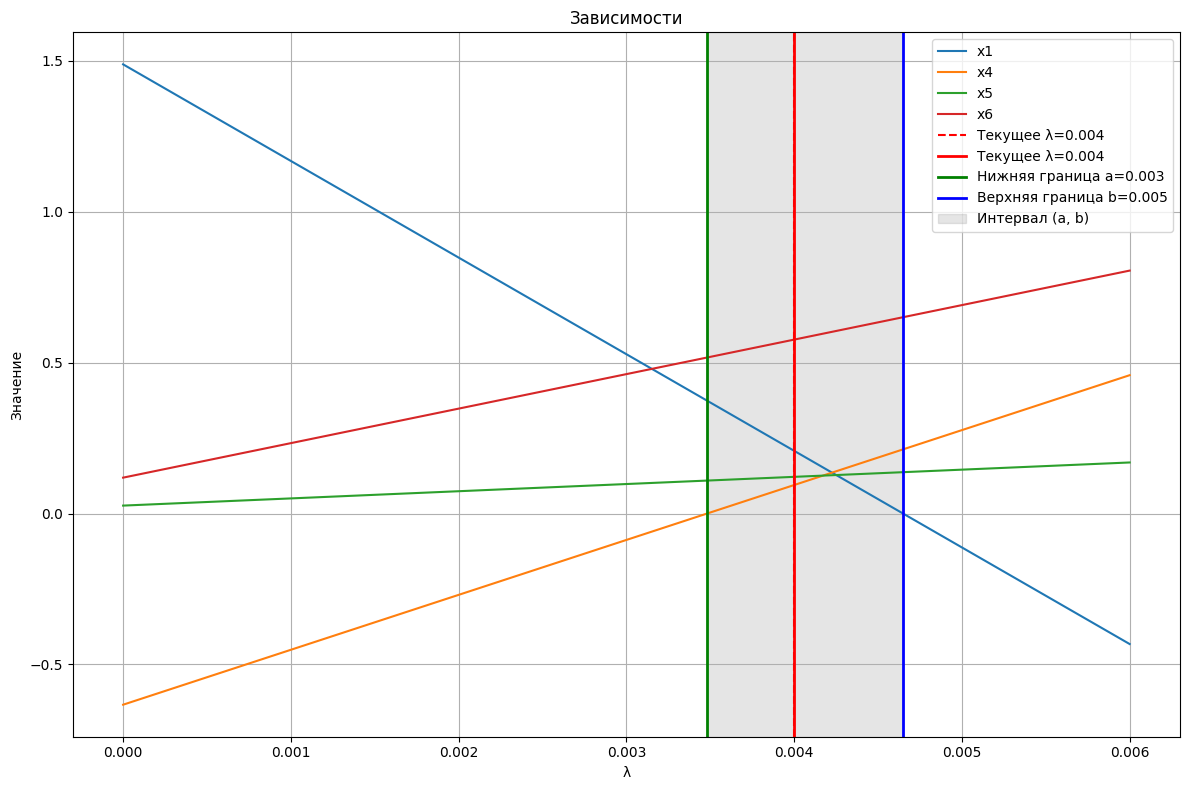

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Исходные данные
cov_matrix = np.array([
    [0.000189, 0.000103, 0.000102, 0.00037,  8.1e-05,  3.7e-05],
    [0.000103, 0.000377, 0.00046,  0.000146, 0.000342, 0.000225],
    [0.000102, 0.00046,  0.000612, 0.000131, 0.000409, 0.000358],
    [0.00037,  0.000146, 0.000131, 0.000808, 0.00016,  8.7e-05],
    [8.1e-05,  0.000342, 0.000409, 0.00016,  0.000425, 0.000194],
    [3.7e-05,  0.000225, 0.000358, 8.7e-05,  0.000194, 0.000407]
])

Lambda = np.array([0.0407, 0.0464, 0.0705, 0.0994, 0.0857, 0.125])

# Текущее состояние
current_lambda = 0.004
external_indices = [1, 2]  # x2 и x3
internal_indices = [0, 3, 4, 5]  # x1, x4, x5, x6

# Формируем подматрицы для внутренних переменных
cov_II = cov_matrix[np.ix_(internal_indices, internal_indices)]
Lambda_I = Lambda[internal_indices]
e = np.ones(len(internal_indices))

# Расширенная матрица системы
A = np.block([
    [cov_II, -e.reshape(-1, 1)],
    [e, 0]
])


# Векторы правой части
b0 = np.zeros(len(internal_indices) + 1)
b0[-1] = 1
b1 = np.hstack([Lambda_I, 0])

# Решаем системы
A = A*2
b0 = b0*2
x0 = np.linalg.solve(A, b0)
x1 = np.linalg.solve(A, b1)

beta = x0[:-1]
u0 = x0[-1]*2
alpha = x1[:-1]
u1 = x1[-1]*2

# Создаем массивы для всех переменных (включая внешние)
all_beta = np.zeros(6)
all_alpha = np.zeros(6)

# Заполняем значения для внутренних переменных
for i, idx in enumerate(internal_indices):
    all_beta[idx] = beta[i]
    all_alpha[idx] = alpha[i]

# Выводим зависимости
print("Зависимости весов от параметра λ:")
for i in range(6):
    print(f"x{i+1}(λ) = {all_alpha[i]:.6f} * λ + {all_beta[i]:.6f}")

print(f"\nu1(λ) = {u1:.6f} * λ + {u0:.6f}")

# Вычисляем значения при λ=0.004
print("\nЗначения при λ=0.004:")
for i in range(6):
    value = all_beta[i] + all_alpha[i] * current_lambda
    print(f"x{i+1} = {value:.6f}")

u1_value = u0 + u1 * current_lambda
print(f"u1 = {u1_value:.6f}")

# Построение графиков зависимостей
lambdas = np.linspace(0, 0.006, 100)

plt.figure(figsize=(12, 8))

# Графики для индексов
for i in range(6):
    if i in internal_indices:
        values = all_beta[i] + all_alpha[i] * lambdas
        plt.plot(lambdas, values, label=f'x{i+1}')

# Отмечаем текущее значение λ
plt.axvline(x=current_lambda, color='red', linestyle='--', label=f'Текущее λ={current_lambda}')

lambda_internal = []
for i in range(len(internal_indices)):
    if abs(alpha[i]) > 1e-8:
        lambda_val = -beta[i] / alpha[i]
        if lambda_val > 0:
            lambda_internal.append((lambda_val, internal_indices[i], 'internal'))

# Вычисляем λ для перехода внешних переменных во внутренние
lambda_external = []
for j in external_indices:
    cov_jI = cov_matrix[j, internal_indices]
    a_j = np.dot(cov_jI, alpha) - Lambda[j] - u1
    b_j = np.dot(cov_jI, beta) - u0
    
    if abs(a_j) > 1e-8:
        lambda_val = -b_j / a_j
        if lambda_val > 0:
            lambda_external.append((lambda_val, j, 'external'))

# Объединяем все критические значения λ
all_lambda = lambda_internal + lambda_external
all_lambda.sort(key=lambda x: x[0])

# Находим соседние угловые точки
lower_lambda = None
upper_lambda = None

for l, idx, transition_type in all_lambda:
    if l < current_lambda:
        lower_lambda = (l, idx, transition_type)
    elif l > current_lambda:
        upper_lambda = (l, idx, transition_type)
        break

# Определяем интервал (a, b)
a = lower_lambda[0] if lower_lambda else 0
b = upper_lambda[0] if upper_lambda else float('inf')




plt.axvline(x=current_lambda, color='red', linewidth=2, label='Текущее λ=0.004')
plt.axvline(x=a, color='green', linewidth=2, label=f'Нижняя граница a={a:.3f}')
plt.axvline(x=b, color='blue', linewidth=2, label=f'Верхняя граница b={b:.3f}')

# Закрашиваем интервал (a, b)
plt.axvspan(a, b, alpha=0.2, color='gray', label='Интервал (a, b)')

plt.xlabel('λ')
plt.ylabel('Значение')
plt.title('Зависимости')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Уравнения частных производных для внешних индексов:
∂Φ/∂x2(λ) = -0.004201 * λ + -0.000010
  При λ=0.004: ∂Φ/∂x2 = -0.000027
∂Φ/∂x3(λ) = -0.013911 * λ + 0.000015
  При λ=0.004: ∂Φ/∂x3 = -0.000040


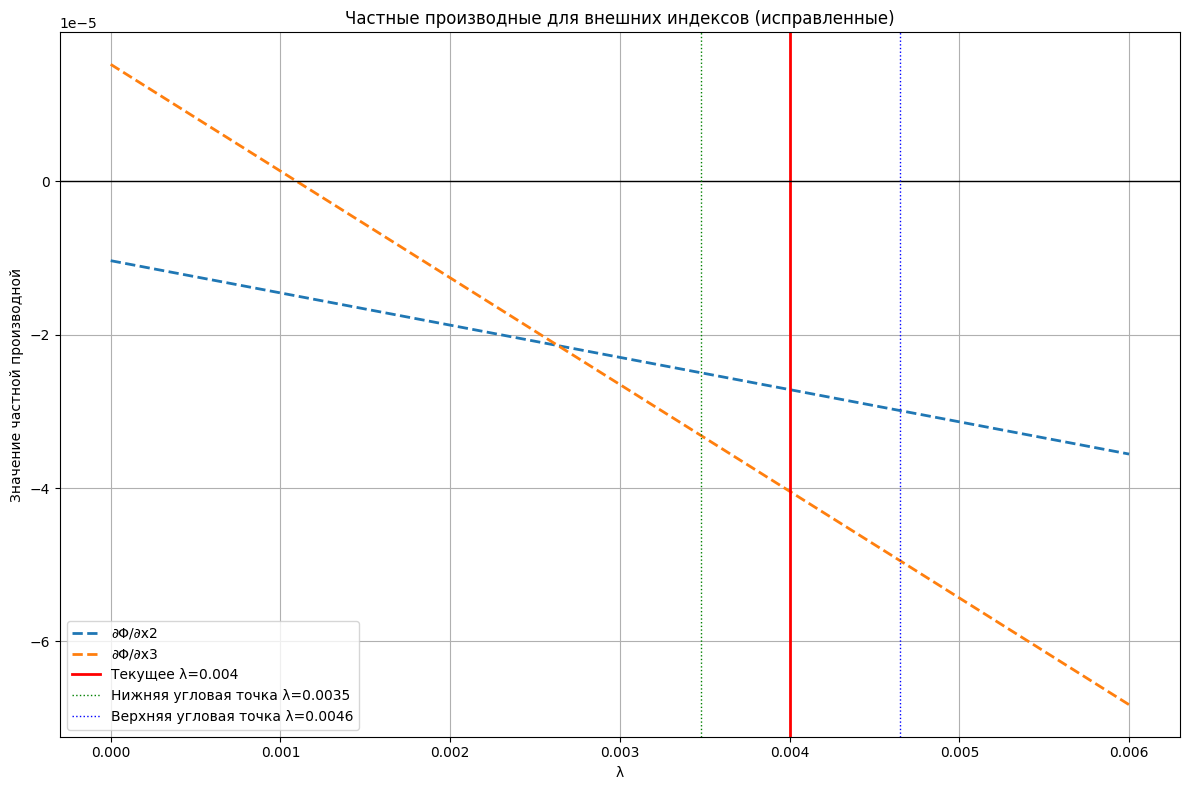

In [11]:
# ИСПРАВЛЕННЫЙ БЛОК ДЛЯ ЧАСТНЫХ ПРОИЗВОДНЫХ
# Вычисление уравнений частных производных для внешних индексов
print("\nУравнения частных производных для внешних индексов:")

plt.figure(figsize=(12, 8))

for j in external_indices:
    # Правильная формула для частных производных внешних переменных
    # ∂Φ/∂x_j = Σ(cov_jk * x_k) - λ * μ_j - u
    
    # Вычисляем коэффициенты правильно
    xi_j = np.dot(cov_matrix[j], all_beta) - u0  # свободный член
    eta_j = np.dot(cov_matrix[j], all_alpha) - Lambda[j] - u1  # коэффициент при λ
    
    print(f"∂Φ/∂x{j+1}(λ) = {eta_j:.6f} * λ + {xi_j:.6f}")
    
    # Вычисляем значение при текущем λ
    current_value = xi_j + eta_j * current_lambda
    print(f"  При λ={current_lambda}: ∂Φ/∂x{j+1} = {current_value:.6f}")
    
    # Вычисляем значения для графика
    values = xi_j + eta_j * lambdas
    plt.plot(lambdas, values, label=f'∂Φ/∂x{j+1}', linestyle='--', linewidth=2)

# Отмечаем важные линии
plt.axvline(x=current_lambda, color='red', linewidth=2, label=f'Текущее λ={current_lambda}')
plt.axhline(y=0, color='black', linewidth=1, linestyle='-')

# Отмечаем угловые точки
if lower_lambda:
    plt.axvline(x=a, color='green', linewidth=1, linestyle=':', label=f'Нижняя угловая точка λ={a:.4f}')
if upper_lambda:
    plt.axvline(x=b, color='blue', linewidth=1, linestyle=':', label=f'Верхняя угловая точка λ={b:.4f}')

plt.xlabel('λ')
plt.ylabel('Значение частной производной')
plt.title('Частные производные для внешних индексов (исправленные)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Уравнения частных производных для внешних индексов:
∂Φ/∂x2(λ) = -0.004201 * λ + -0.000010
  При λ=0.004: ∂Φ/∂x2 = -0.000027
∂Φ/∂x3(λ) = -0.013911 * λ + 0.000015
  При λ=0.004: ∂Φ/∂x3 = -0.000040


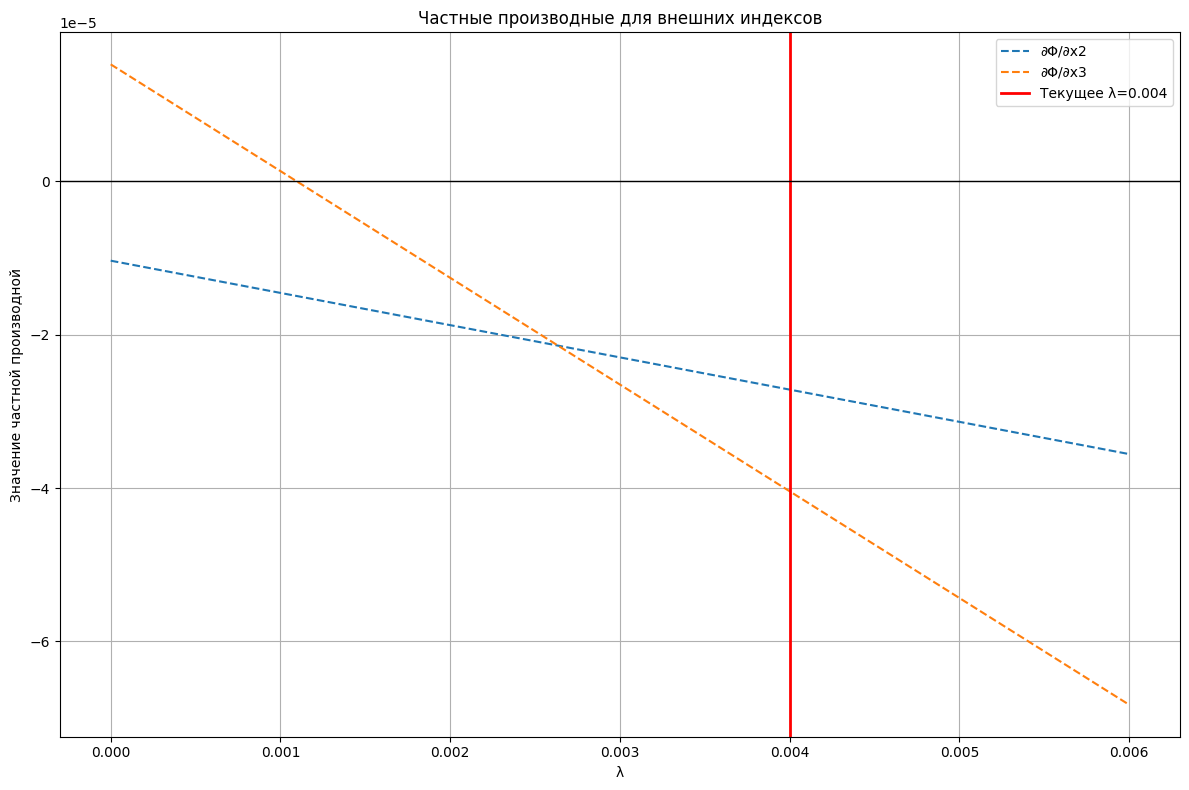

In [10]:
# ПРОБЛЕМА преподаватель сказал, что кривые частных производных должны быть в 1 четверти но этот код рисует их в 3 и 4 четверти
# Вычисление уравнений частных производных для внешних индексов
print("\nУравнения частных производных для внешних индексов:")
for j in external_indices:
    cov_jI = cov_matrix[j, internal_indices]
    
    # Вычисляем коэффициенты ξ_j и η_j
    xi_j = np.dot(cov_jI, beta) - u0
    eta_j = np.dot(cov_jI, alpha) - Lambda[j] - u1
    
    print(f"∂Φ/∂x{j+1}(λ) = {eta_j:.6f} * λ + {xi_j:.6f}")
    
    # Вычисляем значение при текущем λ
    current_value = xi_j + eta_j * current_lambda
    print(f"  При λ={current_lambda}: ∂Φ/∂x{j+1} = {current_value:.6f}")

plt.figure(figsize=(12, 8))

for j in external_indices:
    cov_jI = cov_matrix[j, internal_indices]
    xi_j = np.dot(cov_jI, beta) - u0
    eta_j = np.dot(cov_jI, alpha) - Lambda[j] - u1
    
    # Вычисляем значения для графика
    values = xi_j + eta_j * lambdas
    plt.plot(lambdas, values, label=f'∂Φ/∂x{j+1}', linestyle='--')
    

# Отмечаем текущее значение λ
plt.axvline(x=current_lambda, color='red', linewidth=2, label=f'Текущее λ={current_lambda}')
plt.axhline(y=0, color='black', linewidth=1)

plt.xlabel('λ')
plt.ylabel('Значение частной производной')
plt.title('Частные производные для внешних индексов')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()